In [6]:
# multivariate output 1d cnn example
import tf as tf
from numpy import array
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LSTM, LeakyReLU
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
# split a multivariate sequence into samples

In [7]:
# Загружаем датафрейм
frame = pd.read_csv('Gosloto_5x36_11.10.2020.csv', header=0, sep=';')
frame

# удвляем дату и тираж
frame = frame.drop(columns=['datetime', 'tiraz'], axis=1).astype(float)
frame

,number1,2-number,3-number,4-number,5-number,6-number
0,1.0,26.0,22.0,23.0,8.0,0.0
1,11.0,21.0,18.0,3.0,9.0,0.0
2,26.0,6.0,23.0,5.0,33.0,0.0
3,27.0,4.0,10.0,11.0,29.0,0.0
4,21.0,29.0,28.0,34.0,35.0,0.0
...,...,...,...,...,...,...
20493,24.0,20.0,28.0,35.0,13.0,3.0
20494,24.0,19.0,9.0,7.0,20.0,1.0
20495,26.0,9.0,30.0,35.0,1.0,1.0
20496,27.0,26.0,10.0,32.0,20.0,3.0


In [103]:
in_seq1 = frame["number1"].to_numpy()
in_seq2 = frame["2-number"].to_numpy()
in_seq3 = frame["3-number"].to_numpy()
in_seq4 = frame["4-number"].to_numpy()
in_seq5 = frame["5-number"].to_numpy()
in_seq6 = frame["6-number"].to_numpy()

in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
# horizontally stack columns
#dataset_new = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))
#dataset_new= np.array(range(0,54,1)).reshape(9,6)
dataset_new=np.random.randint(0,10,120000).reshape(20000,6)

In [104]:
validat_x = dataset_new[-101:-1]
validat_y = dataset_new[-1:]
validat_y

array([[3, 0, 0, 1, 5, 2]])

In [105]:
# нужно вычесть 5429+validat_x[!это!:]
dataset = dataset_new[:199899]


In [109]:
n_input = 20
generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=80)

#np.delete(validat)

for i in range(len(generator)):
	x_g, y_g = generator[i]
	print('%s => %s' % (x_g, y_g))
generator.length

[[[3 7 1 5 9 1]
  [8 0 0 9 8 4]
  [3 5 9 8 5 3]
  ...
  [4 9 5 8 3 3]
  [9 1 6 1 7 8]
  [8 4 8 9 9 0]]

 [[8 0 0 9 8 4]
  [3 5 9 8 5 3]
  [2 1 3 2 4 2]
  ...
  [9 1 6 1 7 8]
  [8 4 8 9 9 0]
  [5 8 0 0 2 8]]

 [[3 5 9 8 5 3]
  [2 1 3 2 4 2]
  [6 9 7 9 1 5]
  ...
  [8 4 8 9 9 0]
  [5 8 0 0 2 8]
  [5 2 2 1 1 8]]

 ...

 [[3 5 8 7 6 5]
  [8 5 7 9 0 7]
  [7 7 3 0 3 1]
  ...
  [4 8 9 7 8 6]
  [5 9 0 8 7 7]
  [3 2 1 4 8 9]]

 [[8 5 7 9 0 7]
  [7 7 3 0 3 1]
  [5 9 4 2 8 2]
  ...
  [5 9 0 8 7 7]
  [3 2 1 4 8 9]
  [4 8 6 8 6 0]]

 [[7 7 3 0 3 1]
  [5 9 4 2 8 2]
  [4 2 8 1 8 1]
  ...
  [3 2 1 4 8 9]
  [4 8 6 8 6 0]
  [6 4 4 2 9 4]]] => [[5 8 0 0 2 8]
 [5 2 2 1 1 8]
 [8 5 3 1 4 0]
 [6 6 0 5 0 6]
 [4 3 0 7 3 9]
 [5 4 7 8 7 1]
 [2 4 0 2 2 0]
 [2 6 4 1 6 6]
 [5 0 1 7 7 4]
 [9 6 8 9 5 8]
 [4 4 8 2 6 6]
 [0 7 7 7 9 7]
 [9 9 6 7 4 3]
 [4 8 0 6 2 8]
 [2 8 0 7 4 6]
 [8 1 9 3 9 3]
 [2 6 1 5 2 1]
 [5 4 7 9 9 2]
 [3 5 7 1 4 7]
 [7 9 8 7 6 7]
 [3 9 2 8 3 0]
 [8 9 1 1 0 2]
 [5 6 7 8 1 9]
 [7 6 2 6 1 2]
 [8 0 5

20

In [93]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	print(len(sequences))
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			print('!')
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
# choose a number of time steps
n_steps = 6
# convert into input/output
X, y = split_sequences(dataset_new, n_steps)

20000
!


In [110]:
x_val1 = array([[[36 ,37, 38, 39, 40, 41], [42, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52, 53]]])
y_val1 = array( [[54, 55, 56, 57, 58, 59]])

x_val = array([validat_x])
y_val = array( validat_y)
print (x_val)
print (y_val)
print (x_val1)
print (y_val1)

[[[0 3 3 0 1 3]
  [4 8 0 3 0 2]
  [0 0 8 6 4 0]
  [2 8 6 7 7 3]
  [8 6 7 1 0 7]
  [2 5 0 9 5 8]
  [2 0 7 1 8 6]
  [7 9 0 0 3 5]
  [6 3 4 3 6 4]
  [9 2 0 4 2 9]
  [6 4 7 6 3 2]
  [2 8 9 2 6 7]
  [3 7 9 2 7 6]
  [3 9 6 1 2 8]
  [3 2 8 5 4 1]
  [4 6 9 4 0 2]
  [7 0 8 0 9 2]
  [5 1 1 3 4 9]
  [7 7 9 8 3 3]
  [4 4 2 3 0 4]
  [7 3 7 4 8 4]
  [2 6 6 0 6 1]
  [7 7 5 3 3 7]
  [8 3 2 7 9 1]
  [0 1 6 3 0 8]
  [4 3 6 3 2 7]
  [8 3 4 3 1 5]
  [8 9 1 9 8 5]
  [5 6 1 8 3 5]
  [7 5 9 3 9 4]
  [7 4 1 4 7 2]
  [4 2 0 0 3 5]
  [7 4 3 8 6 9]
  [4 8 7 5 7 7]
  [1 7 1 4 4 7]
  [8 2 6 5 0 6]
  [8 8 9 4 1 8]
  [5 1 3 4 2 2]
  [9 5 6 7 3 5]
  [6 6 3 1 5 9]
  [4 0 5 7 6 3]
  [9 4 3 1 1 6]
  [9 7 8 5 3 7]
  [7 1 6 7 3 0]
  [3 9 3 7 0 9]
  [9 2 7 9 5 6]
  [5 4 9 8 1 9]
  [8 3 3 8 3 7]
  [5 8 0 6 0 8]
  [8 5 3 6 6 0]
  [9 8 1 0 5 7]
  [8 3 1 0 5 2]
  [8 2 6 2 3 4]
  [5 1 9 8 7 1]
  [3 2 4 3 3 6]
  [0 7 6 4 5 0]
  [8 4 0 4 5 8]
  [0 6 2 9 6 3]
  [3 1 4 4 7 8]
  [9 2 9 7 0 0]
  [2 3 7 3 4 0]
  [0 8 1 7 5 7]
  [0 5 1

In [117]:
# the dataset knows the number of features, e.g. 2
#n_features = X.shape[2]
n_features = 6
# define model
model = Sequential()
model.add(Conv1D(filters=500, kernel_size=6, activation='relu', input_shape=(20, n_features)))
#model.add(BatchNormalization())
#model.add(Conv1D(filters=64, kernel_size=45, activation='relu', input_shape=(395, 64)))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(25))
#model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(120, activation='linear'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
#model.fit(X, y, epochs=3, verbose=1)
callbacks = [
  # Остановить обучение если `val_loss` перестанет улучшаться в течение 2 эпох
  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
  # Записать логи TensorBoard в каталог `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
history = model.fit_generator(generator, epochs=1000, verbose=2, validation_data=(generator))#, callbacks=callbacks)
print("Ok!")
# demonstrate prediction

Epoch 1/1000
250/250 - 4s - loss: 9.1093 - val_loss: 8.2597
Epoch 2/1000
250/250 - 3s - loss: 8.3113 - val_loss: 8.2378
Epoch 3/1000
250/250 - 3s - loss: 8.2294 - val_loss: 8.1354
Epoch 4/1000
250/250 - 3s - loss: 8.1464 - val_loss: 8.0058
Epoch 5/1000
250/250 - 3s - loss: 8.0873 - val_loss: 7.9021
Epoch 6/1000
250/250 - 3s - loss: 8.0241 - val_loss: 7.8918
Epoch 7/1000
250/250 - 3s - loss: 7.9536 - val_loss: 7.7102
Epoch 8/1000
250/250 - 3s - loss: 7.9060 - val_loss: 7.6574
Epoch 9/1000
250/250 - 4s - loss: 7.7844 - val_loss: 7.5502
Epoch 10/1000
250/250 - 4s - loss: 7.6922 - val_loss: 7.4324
Epoch 11/1000
250/250 - 3s - loss: 7.5847 - val_loss: 7.2365
Epoch 12/1000
250/250 - 3s - loss: 7.4967 - val_loss: 7.1548
Epoch 13/1000
250/250 - 3s - loss: 7.4012 - val_loss: 7.1257
Epoch 14/1000
250/250 - 4s - loss: 7.3036 - val_loss: 7.1140
Epoch 15/1000
250/250 - 3s - loss: 7.2003 - val_loss: 6.8386
Epoch 16/1000
250/250 - 3s - loss: 7.1018 - val_loss: 6.7190
Epoch 17/1000
250/250 - 3s - loss

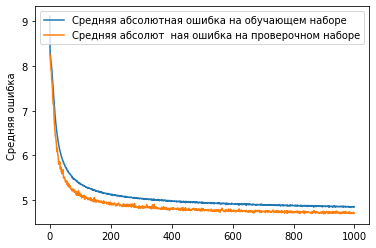

In [118]:
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолют  ная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [119]:
# x_input = array([[70,71,72,73,74,75], [76,77,78,79,80,81], [82,83,84,85,86,87]])
# x_input = x_input.reshape((1, 3, n_features))
x_input = array([dataset_new[-21:-1]])
yhat = model.predict(x_input, verbose=0)
print(yhat)
print("dval",y_val)
print(x_input)
print (dataset_new[-401])
print (dataset_new[-1])
print(y_val-yhat)


[[ 2.9011378 -0.3720994  4.294176   1.7822237  5.215726   1.9048377]]
dval [[3 0 0 1 5 2]]
[[[5 2 1 0 8 2]
  [2 9 5 3 3 8]
  [6 5 0 4 9 8]
  [9 0 7 6 8 4]
  [6 2 6 9 6 6]
  [8 3 4 6 7 5]
  [1 2 6 9 5 4]
  [7 6 2 3 5 6]
  [1 4 7 3 0 1]
  [8 2 1 1 6 4]
  [0 3 0 4 2 7]
  [2 2 3 0 8 1]
  [5 9 1 9 8 3]
  [5 3 2 1 7 4]
  [9 6 1 8 5 3]
  [4 7 1 2 6 7]
  [2 3 9 6 9 0]
  [6 8 7 1 3 2]
  [8 3 2 4 6 2]
  [8 5 2 2 6 2]]]
[9 4 2 5 2 6]
[3 0 0 1 5 2]
[[ 0.09886217  0.3720994  -4.2941761  -0.7822237  -0.2157259   0.09516227]]
